# Macroeconometrics Assignment 2

## Preamble

In [1]:
using Plots
using HypothesisTests
using CSV
using GLM
using DataFrames
using TimeSeries
using StatsBase
using LinearAlgebra
using Distributions
using Dates

cd("/home/rinto/Desktop/Macroeconometrics/Assignment 2")

## Function Definition

In [2]:
# Function to create a Date type column from year and month columns
function create_date_column(df::DataFrame, year_col::Symbol, month_col::Symbol)
    # Extract year and month columns from the DataFrame
    years = df[!, year_col]
    months = df[!, month_col]

    # Create a new Date column by combining year and month
    date_column = [Date(year, month) for (year, month) in zip(years, months)]

    # Add the new Date column to the DataFrame
    df[!, :date] = date_column

    return df
end


# Function to create a time array from a data DataFrame
function create_time_array(df::DataFrame, date_col::Symbol, series_col::Symbol)
    
    df_subset = select(df, [series_col, date_col]);
    timeArray = TimeArray(df_subset; timestamp = date_col);

    return timeArray

end


# This function seasonally adjusts the data
function seasonal_adjust(series::TimeArray)
    months = timestamp(series);
    months = Dates.month.(months);
    months = Char.(months);
    df = DataFrame([months, values(series)], [:MONTH, :SERIES]);
    model = lm(@formula(SERIES ~ MONTH), df)
    seasonal_component = predict(model);
    seasonal_component = TimeArray(timestamp(series), seasonal_component)
    adjusted_series = series .- seasonal_component;
    
    return adjusted_series
    
end


# This function plots a correlogram
function plotCorrelogram(series::TimeArray)

    bar(timestamp(series), values(series))
    series_autocorr = autocor(values(series), collect(1:12); demean = true)
    t = 1:length(series_autocorr);
    CI_up = quantile(Normal(), 1 - .025) / sqrt(length(values(series)));
    CI_down = -CI_up;

    bar(t, series_autocorr, ylims = [-.5, .5], xlabel = "lags", ylabel = "autocorrelation", label = "ACF")
    hline!([CI_up, CI_down], label = "95% CI")

end 


# This function conducts a sequential Wald test up to maxLags
function SequentialWaldTest(y, maxLags)
    
    results = DataFrame(Lags = Int[], TestStat = Float32[], H0 = String[]);
    
    for i in 1:maxLags
        p = maxLags - i + 1;
        push!(results, (Lags = p, TestStat = WaldTest(y, p)[1][1], H0 = WaldTest(y, p)[2]));
    end

    return results

end


# This function performs a Wald test on lags number of lags
function WaldTest(y, lags)

    T = size(y, 1);
    k = size(y, 2);
    p = lags;
    
    B̂, Σ̂, ϵ̂  = VAR(y, p);
    β̂ = vec(B̂);
    X = [ones(T-p) [y[p + 1 - i:end - i, :] for i in 1:p]...];
    Γ̂  = X'X;
    A = Matrix(I, k*(k*p+1), k*(k*p+1)); # hypothesis matrix
    # A = A[1:end .∉ [[1, 1+(k*p+1), 1+2*(k*p+1)]], 1:end]; # exclude the intercepts from the hypotheses
    A = A[1:end .∉ [[1+i*(k*p+1) for i in 0:(k-1)]], 1:end]; # exclude the intercepts from the hypotheses
    c = zeros(size(A, 1), 1);

    denom = A * kron(Σ̂ , inv(Γ̂)) * A';
    num = (A * β̂ - c);
    W = num' * inv(denom) * num;
    
    critical_value = quantile(Chisq(size(A, 1)), 1 - .05);
    
    if W[1] > critical_value 
        H0 = "reject H0"
    else
        H0 = "fail to reject H0"
    end
    
    return W, H0
    
end

WaldTest(y::TimeArray, p) = WaldTest(values(y), p)


# This function performs an Akaike Information Criterion test up to maxLags
function AICTest(y, maxLags)
    T = size(y, 1);
    AIC = zeros(maxLags);
    results = DataFrame(Lags = Int[], AIC_Score = Float32[]);
    for i in 1:maxLags
        p = maxLags - i + 1;
        k = size(y, 2);
        Σ  = VAR(y, p)[2];
        AIC[i] = log(det(Σ)) + 2 / T * k * (p*k + 1);
        push!(results, (Lags = p, AIC_Score = AIC[i]));
    end

    optimal_p = maxLags - argmin(AIC) + 1;

    return results, optimal_p

end


# This function performs a Bayesian Information Criterion test up to maxLags
function BICTest(y, maxLags)
    T = size(y, 1);
    BIC = zeros(maxLags);
    results = DataFrame(Lags = Int[], BIC_Score = Float32[]);
    for i in 1:maxLags
        p = maxLags - i + 1;
        k = size(y, 2);
        Σ  = VAR(y, p)[2];
        BIC[i] = log(det(Σ)) + log(T) / T * k * (p*k + 1);
        push!(results, (Lags = p, BIC_Score = BIC[i]));
    end

    optimal_p = maxLags - argmin(BIC) + 1;

    return results, optimal_p

end


# A function which allows us to estimate a VAR(p) model 
function VAR(y, p)
    T = size(y, 1)
    k = size(y, 2)
    Y = y[p+1:end, :]
    X = [ones(T-p) [y[p + 1 - i:end - i, :] for i in 1:p]...]
    B̂ = inv(X'X)*X'Y
    ε̂ = Y - X*B̂
    Σ̂ = (ε̂'*ε̂)/(T - p)
    return B̂, Σ̂, ε̂
end

VAR(y::TimeArray, p) = VAR(values(y), p)


function μΦ(B, k, p)
    μ = B[1, :]
    Φ = hcat([B[((i-1)*k:i*k - 1) .+ 2, :]' for i in 1:p]...)
    return μ, Φ
end;


function F(Φ, k, p)
    F = [Φ; 
         I(k*(p-1)) zeros(k*(p-1), k)]
    return F
end


function Cₛ(B̂, h)
    k = size(B̂, 2)
    p = (size(B̂, 1) - 1) ÷ k
    Φ̂ = μΦ(B̂, k, p)[2]
    FΦ̂ = F(Φ̂, k, p)
    #C = (FΦ̂^h)[1:k, 1:k]
    C = map(i -> (FΦ̂^i)[1:k, 1:k], h)
    return C
end


# This function computes the SIRF
function SIRF(B̂, Σ̂, h)
    # obtain the h-step ahead reduced form responses
    C = Cₛ(B̂, h)
    # obtain lower triangular Choleski factor
    Θ̂₀ = cholesky(Σ̂).L
    # for each (i, j) collect [Θ̂ₕ]ᵢⱼ
    Θ̂ₕ = cat(map(c -> c*Θ̂₀, C)...; dims = 3)
    return Θ̂ₕ
end


# This function draws a bootstrap sample
function bootstrap_sample(Φ̂, y, p, T, Σ̂, μ̂)
    y = y'
    k = size(y, 1)
    yᵇ = hcat([y[:, t] for t in 1:p]..., [zeros(k) for _ in p+1:T]...)
    εᵇ = rand(MvNormal(Σ̂), T-p)
    for t in p+1:T
        yᵇ[:, t] = μ̂ + sum([Φ̂[:, (1:k) .+ i*k] * yᵇ[:, t-1-i] for i in 0:(p-1)]) + εᵇ[:, t-p]
    end
    return yᵇ
end


#=
# This function draws a bootstrap sample
function bootstrap_sample(Φ̂v, y, p, T, Σ̂, μ̂)
    yᵇ = vcat([y'[:, t] for t in 1:p], [zeros(2) for t in p+1:T])
    for t in p+1:T
        yᵇ[t] = Φ̂v'*yᵇ[(t-1):-1:(t-p)] + μ̂ + rand(MvNormal(Σ̂))
    end
    return hcat(yᵇ...)
end
=#

bootstrap_sample(Φ̂v, y::TimeArray, p, T, Σ̂, μ̂) = bootstrap_sample(Φ̂v, values(y), p, T, Σ̂, μ̂);


# This function returns a confidence interval around a SIRFs using the bootsrap method
function bootstrap(y, p, g, B, α, args...)
    T, k = size(y)
    B̂, Σ̂, ε̂ = VAR(y, p)
    μ̂, Φ̂ = μΦ(B̂, k, p)
    ĝ = stack([g(bootstrap_sample(Φ̂, y, p, T, Σ̂, μ̂), p, args...) for i in 1:B])
    ĝslice = eachslice(ĝ; dims = Tuple(1:ndims(ĝ) - 1))
    ĝl = quantile.(ĝslice, α/2)
    ĝu = quantile.(ĝslice, 1 - α/2)
    return ĝl, ĝu
end


#=
function bootstrap(y, p, g, B, α, args...)
    T, k = size(y)
    B̂, Σ̂, ε̂ = VAR(y, p)
    μ̂, Φ̂ = μΦ(B̂, k, p)
    Φ̂v = [Φ̂[:, (1:k) .+ i*k] for i in 0:(p-1)]
    ĝ = stack([g(bootstrap_sample(Φ̂v, y, p, T, Σ̂, μ̂), p, args...) for i in 1:B])
    ĝslice = eachslice(ĝ; dims = Tuple(1:ndims(ĝ) - 1))
    ĝl = quantile.(ĝslice, α/2)
    ĝu = quantile.(ĝslice, 1 - α/2)
    return ĝl, ĝu
end
=#


# This function estimates a VAR and its corresponding SIRF using recursive (Cholesky) identification
function recursive_id(y, p, H)

    B̂, Σ̂, ε̂ = VAR(y', p)
    H = 0:48
    Θ̂ = SIRF(B̂, Σ̂, H)
    return Θ̂ 

end 


# This function estimates a VAR and its corresponding SIRF using an external instrument
function iv_id(y, p, H, instrument, index)
    
    k = size(y, 1)
        
    B̂, Σ̂, ε̂ = VAR(y', p);

    b̂ = zeros(k, 1);
    
    for i in 1:k
        b̂[i, 1] = cov(ε̂[:, i], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
    end 

    #sizediff = size(ε̂, 1) - size(ff4_tc, 1)
    #ε̂ = ε̂[sizediff+1:end, :] 

    #for i in 1:k
    #    b̂[i, 1] = cov(ε̂[:, i], values(ff4_tc)) / StatsBase.var(values(ff4_tc));
    #end 

    b̂ᵢ = b̂[index, 1];
    Θ̂₀ᵢ = b̂ ./ b̂ᵢ
    
    Cₕ = Cₛ(B̂, H);
    
    Θ̂ₕ = cat(map(c -> c*Θ̂₀ᵢ, Cₕ)...; dims = 2);
    return Θ̂ₕ

end 



iv_id (generic function with 1 method)

## Data Loading

In [3]:
data = CSV.read("VAR_data.csv", DataFrame);
instrument = CSV.read("factor_data.csv", DataFrame);

# Call the function to create the date column
data = create_date_column(data, :year, :month);
instrument = create_date_column(instrument, :year, :month);
instrument = dropmissing(instrument);

logip = create_time_array(data, :date, :logip);
logcpi = create_time_array(data, :date, :logcpi);
gs1 = create_time_array(data, :date, :gs1);
gs2 = create_time_array(data, :date, :gs2);
ebp = create_time_array(data, :date, :ebp);
ff4_tc = create_time_array(instrument, :date, :ff4_tc);

## Plotting and Transformations

I begin by inspecting the data for potential non-stationarity. Unlike Gertler and Karadi (2015), I decide to first difference some of the series to ensure consistency in my VAR(p) estimators. Moreover, stationarity is a necessary condition to ensure consistency of the bootstrap method, which is one more reason to first difference the series. The downside is that I lose statistical power in my estimators through loss of information (e.g. by losing the trend component) and observations. It might also lead to a weaker instrument in Q5. 

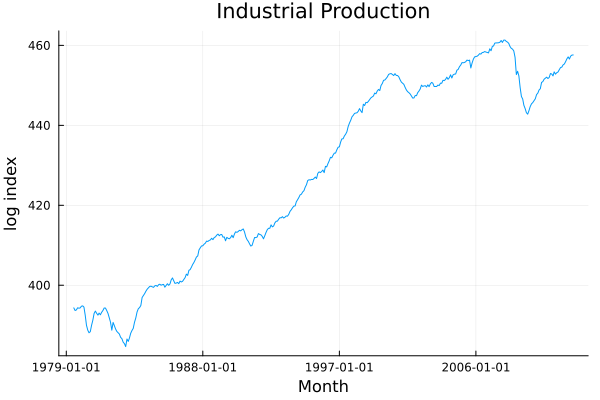

In [4]:
logip_plt = plot(
    logip, 
    title = "Industrial Production",
    xlabel = "Month", 
    ylabel = "log index", 
    label = false
    )

In [5]:
ADFTest(values(logip), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000268086

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     1.0000

Details:
    sample size in regression:          394
    number of lags:                     1
    ADF statistic:                      3.32213
    Critical values at 1%, 5%, and 10%: [-2.57141 -1.9417 -1.61617]


The series is trending upwards and the ADF test confirms that the series has a unit root. Therefore, I take the first difference of the series to eliminate the trend, such that it can be interpreted as the percentage growth rate of industrial production.

In [6]:
d1_logip = diff(logip);

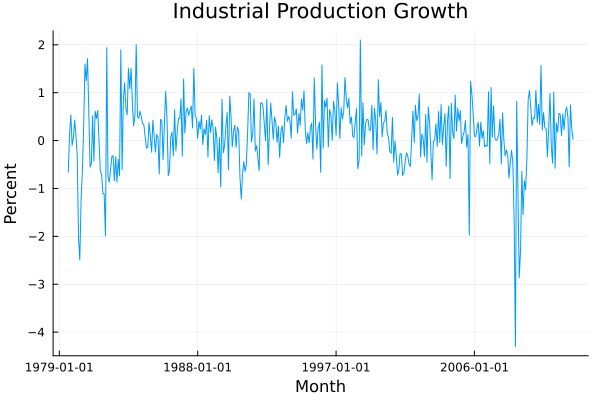

In [7]:
d1_logip_plt = plot(
    d1_logip, 
    title = "Industrial Production Growth",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [8]:
ADFTest(values(d1_logip), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.498276

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-14

Details:
    sample size in regression:          393
    number of lags:                     1
    ADF statistic:                      -8.77738
    Critical values at 1%, 5%, and 10%: [-2.57142 -1.9417 -1.61616]


The series is now indeed stationary.

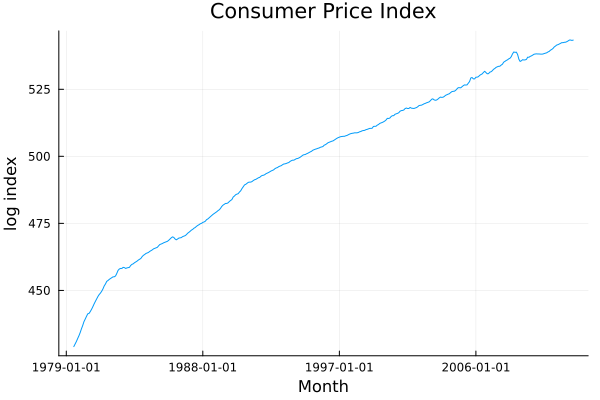

In [9]:
logcpi_plt = plot(
    logcpi, 
    title = "Consumer Price Index",
    xlabel = "Month", 
    ylabel = "log index", 
    label = false
    )

In [10]:
ADFTest(values(logcpi), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.000211501

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     1.0000

Details:
    sample size in regression:          394
    number of lags:                     1
    ADF statistic:                      6.30373
    Critical values at 1%, 5%, and 10%: [-2.57141 -1.9417 -1.61617]


The series appears to trend upwards, and the ADF test indicates the presence of a unit root. I again take the first difference of the series to obtain CPI expressed as an inflation rate.

In [11]:
inflation = diff(logcpi);

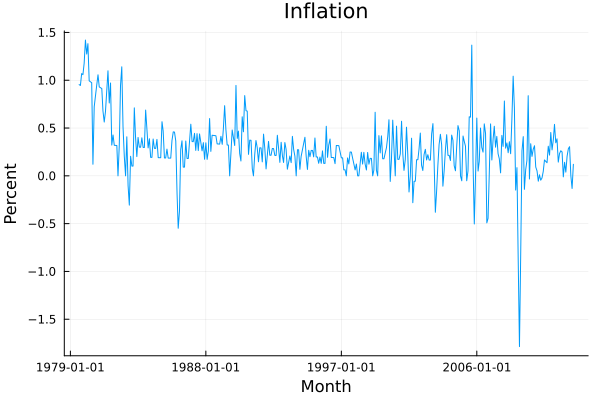

In [12]:
inflation_plt = plot(
    inflation, 
    title = "Inflation",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [13]:
ADFTest(values(inflation), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.208232

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-08

Details:
    sample size in regression:          393
    number of lags:                     1
    ADF statistic:                      -6.33287
    Critical values at 1%, 5%, and 10%: [-2.57142 -1.9417 -1.61616]


The series is now stationary.

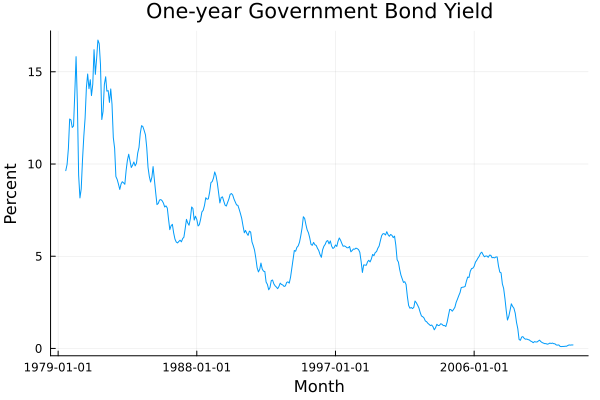

In [14]:
gs1_plt = plot(
    gs1, 
    title = "One-year Government Bond Yield",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [15]:
ADFTest(values(gs1), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00546686

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1048

Details:
    sample size in regression:          394
    number of lags:                     1
    ADF statistic:                      -1.59259
    Critical values at 1%, 5%, and 10%: [-2.57141 -1.9417 -1.61617]


The series is clearly trending downwards and it has a unit root. Therefore, I take the first difference of the series to obtain the one-year government bond yield expressed in terms of percentage point growth (I do not take the log, for the sake of interpretability).

In [16]:
d1_gs1 = diff(gs1);

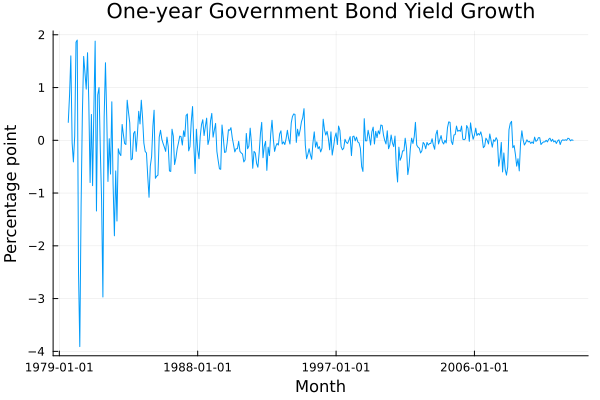

In [17]:
d1_gs1_plt = plot(
    d1_gs1, 
    title = "One-year Government Bond Yield Growth",
    xlabel = "Month", 
    ylabel = "Percentage point", 
    label = false
    )

In [18]:
ADFTest(values(d1_gs1), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.817726

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-25

Details:
    sample size in regression:          393
    number of lags:                     1
    ADF statistic:                      -14.9808
    Critical values at 1%, 5%, and 10%: [-2.57142 -1.9417 -1.61616]


The series is now stationary.

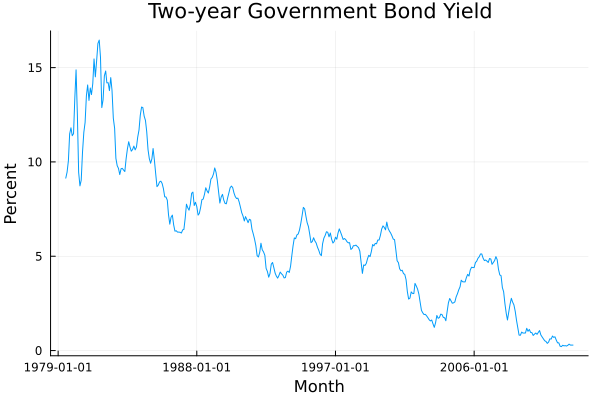

In [19]:
gs2_plt = plot(
    gs2, 
    title = "Two-year Government Bond Yield",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [20]:
ADFTest(values(gs2), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00433641

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.1414

Details:
    sample size in regression:          394
    number of lags:                     1
    ADF statistic:                      -1.43405
    Critical values at 1%, 5%, and 10%: [-2.57141 -1.9417 -1.61617]


The two-year government bond yield shows a similar trend as the one-year government bond yield. Again, I take the first difference.

In [21]:
d1_gs2 = diff(gs2);

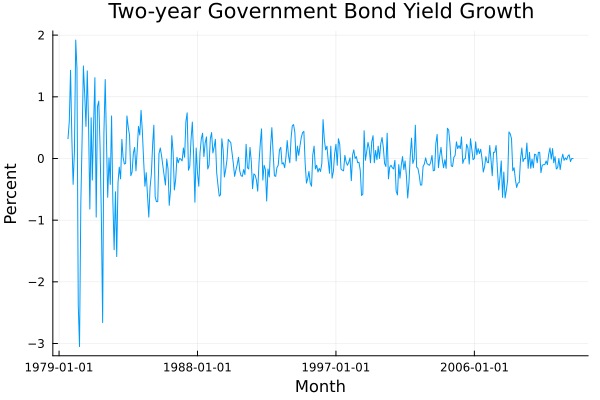

In [22]:
d1_gs2_plt = plot(
    d1_gs2, 
    title = "Two-year Government Bond Yield Growth",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [23]:
ADFTest(values(d1_gs2), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.817086

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-25

Details:
    sample size in regression:          393
    number of lags:                     1
    ADF statistic:                      -14.8744
    Critical values at 1%, 5%, and 10%: [-2.57142 -1.9417 -1.61616]


The series now appears stationary.

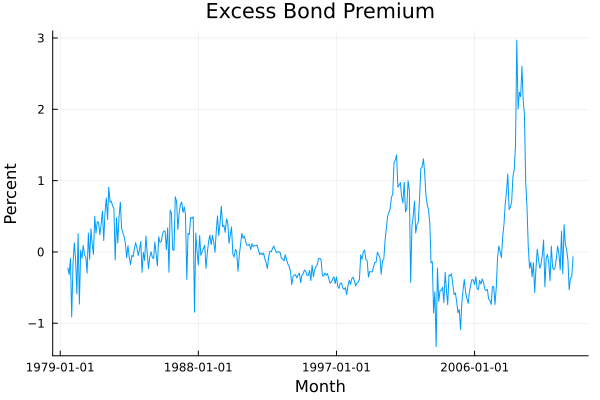

In [24]:
ebp_plt = plot(
    ebp, 
    title = "Excess Bond Premium",
    xlabel = "Month", 
    ylabel = "Percent", 
    label = false
    )

In [25]:
ADFTest(values(ebp), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.0972781

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     0.0002

Details:
    sample size in regression:          394
    number of lags:                     1
    ADF statistic:                      -3.77517
    Critical values at 1%, 5%, and 10%: [-2.57141 -1.9417 -1.61617]


The series is already stationary, so no transformations are made.

In [26]:
# merge the series
y = merge(d1_logip, inflation, d1_gs1, ebp);

## VAR Estimation

I select gs1 over gs2 as the monetary policy tool in my VAR(p), as Gertler and Karadi (2015) report that the instrument ff4_tc is stronger on gs1. I begin by runing a sequential Wald test, an AIC test and a BIC test to find the optimal number of lags. I begin by testing up to 12 lags, by supposing that the data is not autocorrelated beyond one year. 

In [27]:
maxLags = 12
SequentialWaldTest(y, maxLags)

12×3 DataFrame
 Row │ Lags   TestStat  H0        
     │ Int64  Float32   String    
─────┼────────────────────────────
   1 │    12   2435.93  reject H0
   2 │    11   2330.87  reject H0
   3 │    10   2252.47  reject H0
   4 │     9   2291.41  reject H0
   5 │     8   2208.93  reject H0
   6 │     7   2182.41  reject H0
   7 │     6   2098.92  reject H0
   8 │     5   2004.35  reject H0
   9 │     4   1853.69  reject H0
  10 │     3   1797.7   reject H0
  11 │     2   1715.89  reject H0
  12 │     1   1410.74  reject H0

In [28]:
maxLags = 12;
AICTest(y, maxLags)[1]

12×2 DataFrame
 Row │ Lags   AIC_Score 
     │ Int64  Float32   
─────┼──────────────────
   1 │    12   -8.75187
   2 │    11   -8.68257
   3 │    10   -8.65424
   4 │     9   -8.55144
   5 │     8   -8.41483
   6 │     7   -8.41707
   7 │     6   -8.36623
   8 │     5   -8.28367
   9 │     4   -8.1867
  10 │     3   -8.16497
  11 │     2   -8.09593
  12 │     1   -7.82987

In [29]:
AICTest(y, maxLags)[2]

12

In [30]:
BICTest(y, maxLags)[1]

12×2 DataFrame
 Row │ Lags   BIC_Score 
     │ Int64  Float32   
─────┼──────────────────
   1 │    12   -6.77754
   2 │    11   -6.86941
   3 │    10   -7.00225
   4 │     9   -7.06062
   5 │     8   -7.08518
   6 │     7   -7.24859
   7 │     6   -7.35892
   8 │     5   -7.43753
   9 │     4   -7.50173
  10 │     3   -7.64117
  11 │     2   -7.7333
  12 │     1   -7.62841

In [31]:
BICTest(y, maxLags)[2]

2

The sequential Wald test rejects all the null hypotheses that at least one lag is insignificant, while the AIC test indicates 12 lags and the BIC test selects 2 lags. I select 12 lags given that the sequential Wald test and the AIC test agree. I further test the validity of the model by plotting the correlograms of the residuals and by running a Wald test on the VAR residuals.

In [32]:
# run a VAR(1) model
p = 12;
var = VAR(y, p);

res = var[3];

res_df = data[(p+2):end, :];
res_df = select(res_df, :date)
res_df[!, :logip_res] = res[:, 1];
res_df[!, :inflation_res] = res[:, 2];
res_df[!, :gs1_res] = res[:, 3];
res_df[!, :ebp_res] = res[:, 4];

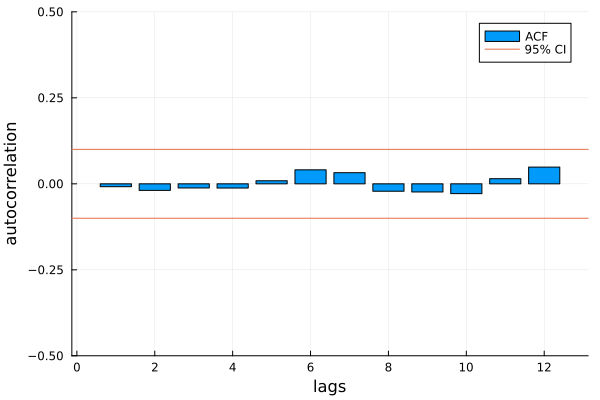

In [33]:
logip_res = create_time_array(res_df, :date, :logip_res);
plotCorrelogram(logip_res)

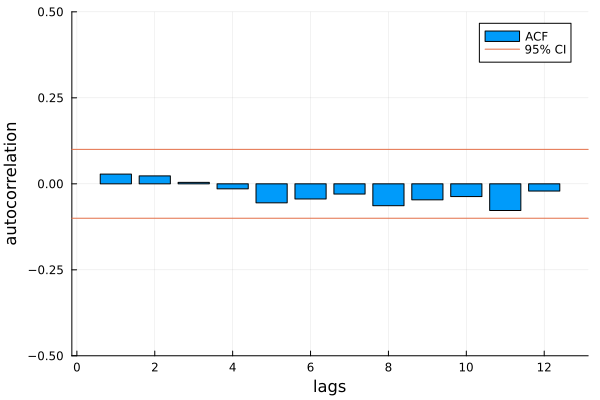

In [34]:
inflation_res = create_time_array(res_df, :date, :inflation_res);
plotCorrelogram(inflation_res)

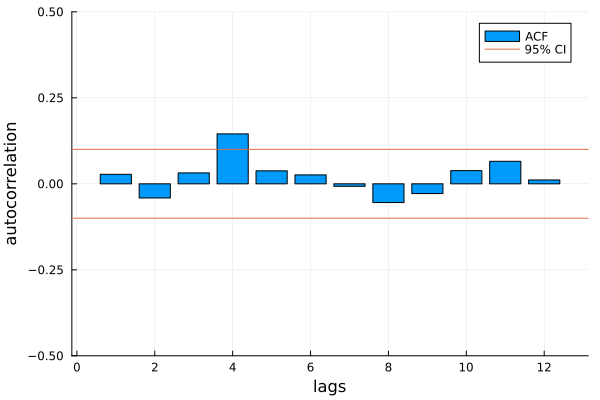

In [35]:
gs1_res = create_time_array(res_df, :date, :gs1_res);
plotCorrelogram(gs1_res)

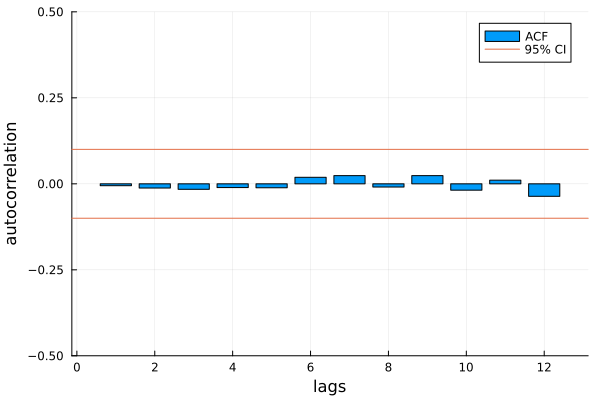

In [36]:
ebp_res = create_time_array(res_df, :date, :ebp_res);
plotCorrelogram(ebp_res)

In [37]:
WaldTest(res, 12)

([112.86540768430902;;], "fail to reject H0")

The correlograms and the Wald test on the VAR with the residuals suggest that the model is well-specified. I therefore proceed with a VAR(12).

## Impulse Response Function

Since we are seeking partial identification, only the ordering of gs1 relative to the other variables matters while estimating the SIRF through recursive identification. I decided to opt for the ordering [industrial_production, inflation, monetary policy, excess bond premium], by supposing that only excess bond premium reacts contemporaneously to a change in the policy rate.

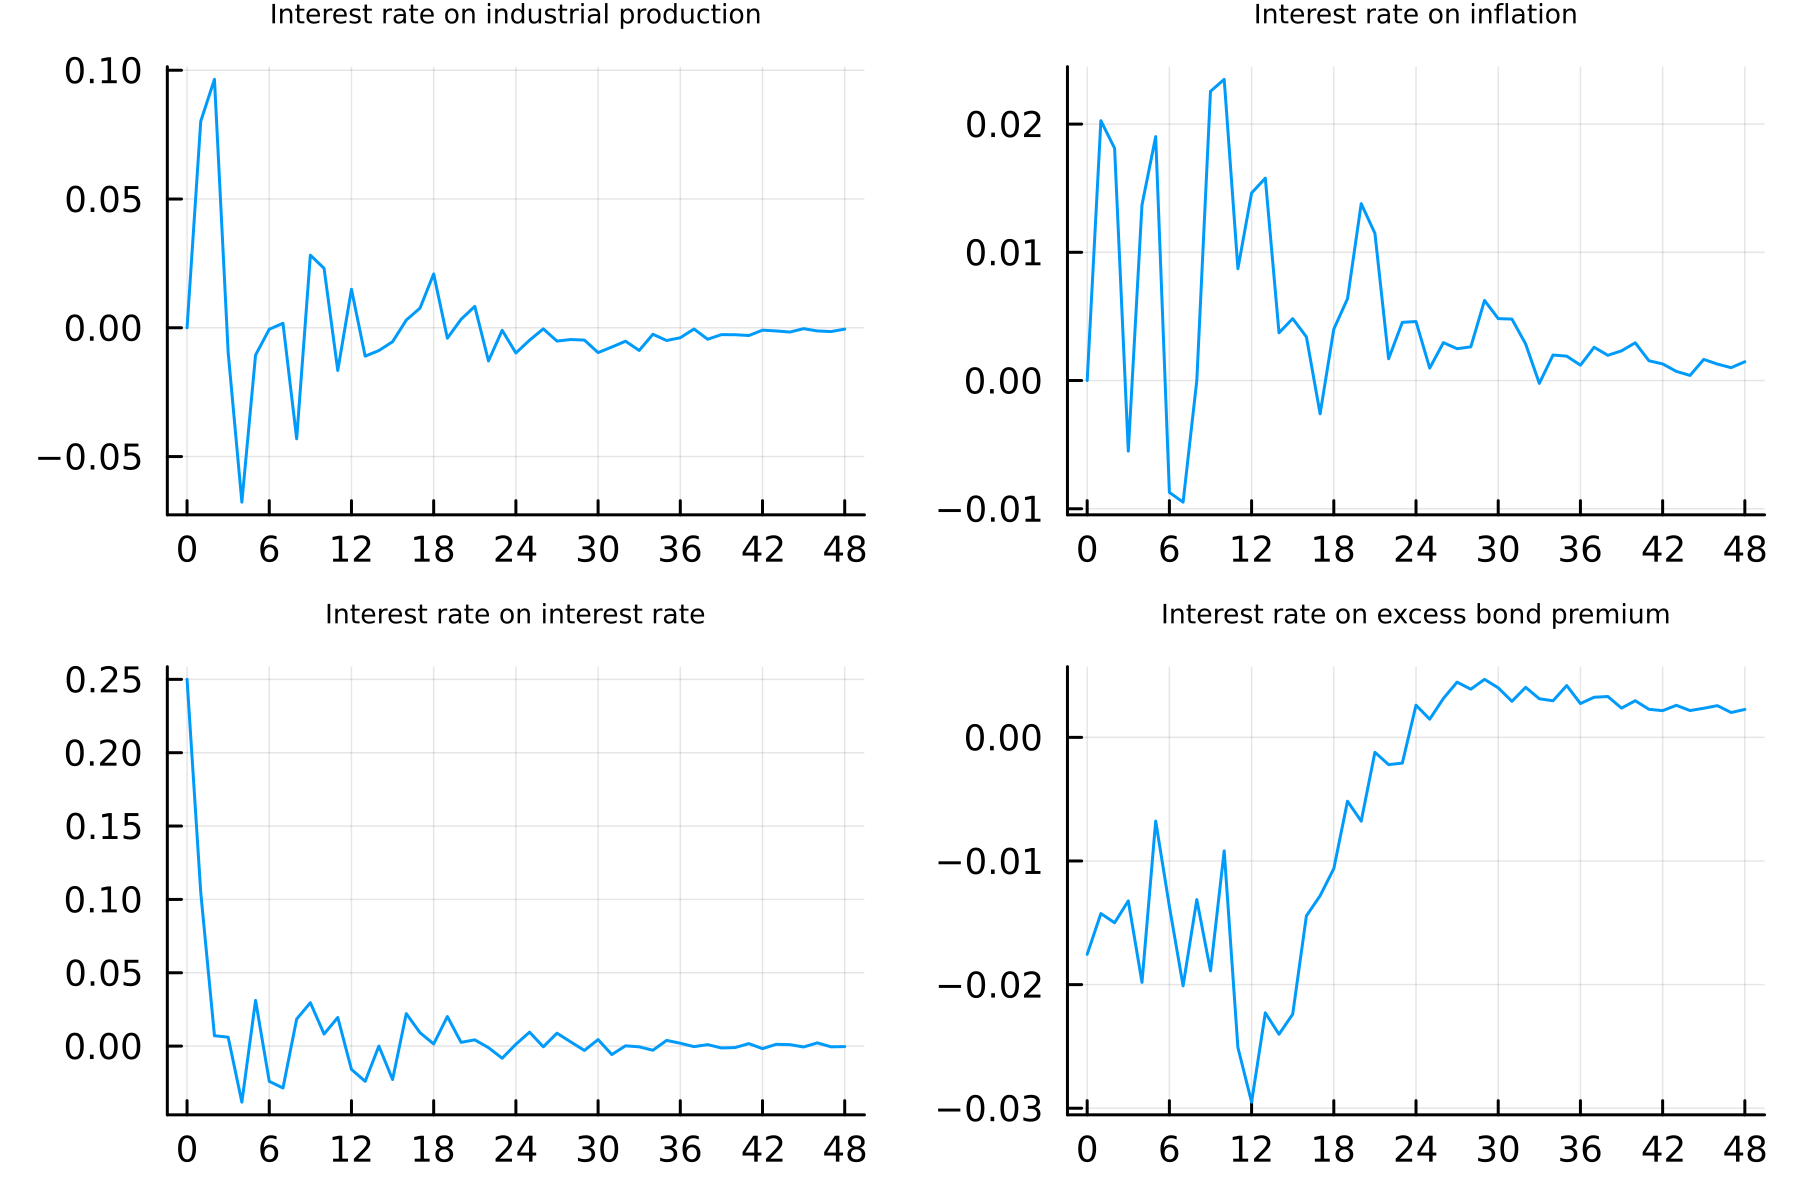

In [38]:
y = merge(d1_logip, inflation, d1_gs1, ebp); # here, gs1 is the policy instrument
p = 12;
B̂, Σ̂, ε̂ = VAR(y, p);

H = 0:48
Θ̂ = SIRF(B̂, Σ̂, H);

# scale such that variables react to a 25bp increase in mpi
Θ̂_mps  = Θ̂[:, 3, :] ./ Θ̂[3, 3, 1] * .25; 

fig = plot(H, 
collect(eachslice(Θ̂_mps; dims = 1)), 
layout = (2,2), 
legend = :none, 
title = permutedims(["Interest rate on "*i for i in [
    "industrial production", 
    "inflation", 
    "interest rate", 
    "excess bond premium"
    ]
    ]),
titlefontsize = 6, xticks = 0:6:48, dpi = 300)

A positive monetary policy shock results in a temporary increase in industrial production and a significantly persistent increase in inflation (i.e. a price puzzle), suggesting that the monetary policy shock may not be truly exogenous. Moreover, the monetary policy shock decreses the excess bond premium, which is unexpected if we suppose that an increase in the interest rate makes borrowing more costly and increases the risk premium on a bond. Next, I add a 95% confidence interval around the point estimates above using the bootstrap method.

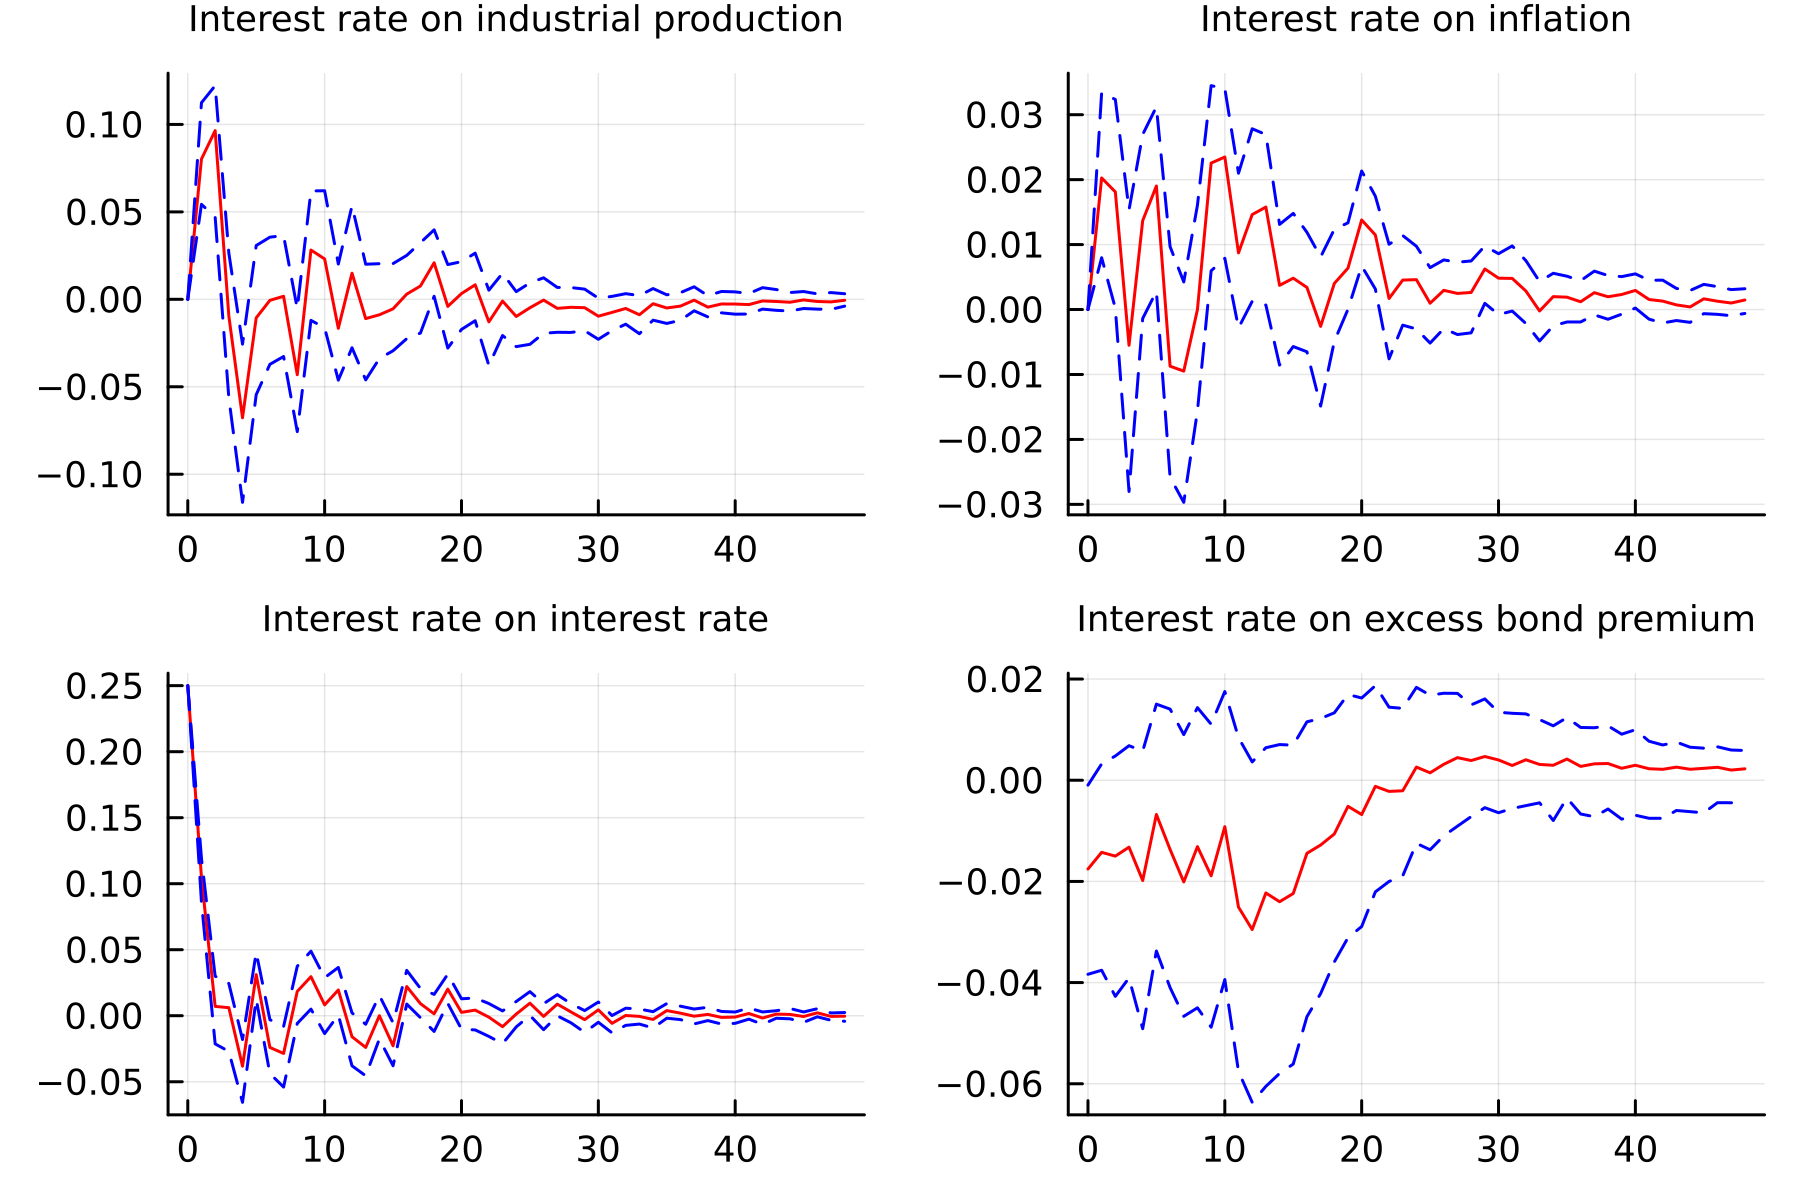

In [39]:
LR_l, LR_u = bootstrap(y, p, recursive_id, 100, 0.1, H);

LR_l_mps = LR_l[:, 3, :] ./ LR_l[3, 3, 1] * .25; 
LR_u_mps = LR_u[:, 3, :] ./ LR_u[3, 3, 1] * .25; 

titles = ["industrial production", "inflation", "interest rate", "excess bond premium"]

plot([plot(
    H, 
    [collect(eachslice(Θ̂_mps; dims = 1))[i] collect(eachslice(LR_l_mps; dims = 1))[i] collect(eachslice(LR_u_mps; dims = 1))[i]], 
    title = "Interest rate on "*titles[i], 
    titlefontsize = 8, color = [:red :blue :blue], 
    linestyle = [:solid :dash :dash]) for i in 1:4]..., 
    fillalpha = 1, layout = (2, 2), 
    legend = :none, 
    dpi = 300
    )

The confidence intervals are tight, suggesting that the model is efficient.

## Instrumental Variable Estimation

I now use the surprise change in the 3-month Federal Funds futures rate around FOMC announcements as an external instrument to identify the mps.

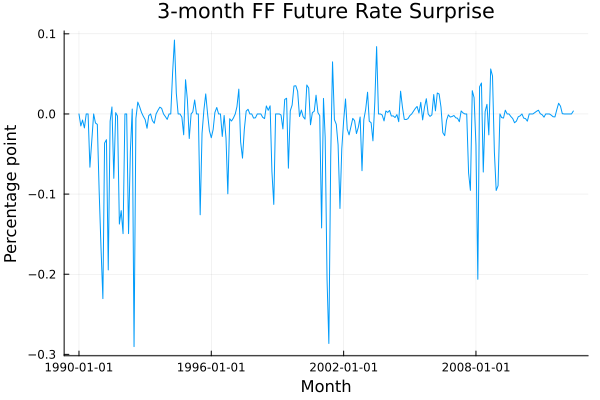

In [40]:
ff4_tc_plt = plot(
    ff4_tc, 
    title = "3-month FF Future Rate Surprise",
    xlabel = "Month", 
    ylabel = "Percentage point", 
    label = false
    )

In [41]:
ADFTest(values(ff4_tc), :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.682014

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-16

Details:
    sample size in regression:          268
    number of lags:                     1
    ADF statistic:                      -9.8909
    Critical values at 1%, 5%, and 10%: [-2.57407 -1.94204 -1.61587]


The series is stationary, so I decided to keep ff4_tc in levels.

Next, I collect the residuals on each variable from the VAR(12) in Q2 and regress each residuals on the instrument. The coefficients are stored in a vector $\hat{b}$, which I use to compute $\hat{\Theta}_{0,i} = \hat{b} / \hat{b}_{i}$, $i \in \{1, ..., 4\}$ to obtain the SIRF.

In [42]:
sizediff = size(y, 1) - size(ff4_tc, 1)
y = y[(sizediff+1):end]

p = 12;
B̂, Σ̂, ε̂ = VAR(y, p);

b̂ = zeros(4, 1);

b̂[1, 1] = cov(ε̂[:, 1], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[2, 1] = cov(ε̂[:, 2], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[3, 1] = cov(ε̂[:, 3], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[4, 1] = cov(ε̂[:, 4], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);

b̂₃ = b̂[3, 1];

Θ̂₀₃ = b̂ ./ b̂₃

4×1 Matrix{Float64}:
  0.20165788388350714
 -0.099231142823486
  1.0
  0.6058722000229853

In [43]:
Cₕ = Cₛ(B̂, H);
Θ̂ₕ = cat(map(c -> c*Θ̂₀₃, Cₕ)...; dims = 2);

# scale such that variables react to a 25bp increase in mpi
Θ̂_mps  = Θ̂ₕ * .25; 

Θ̂_mps;

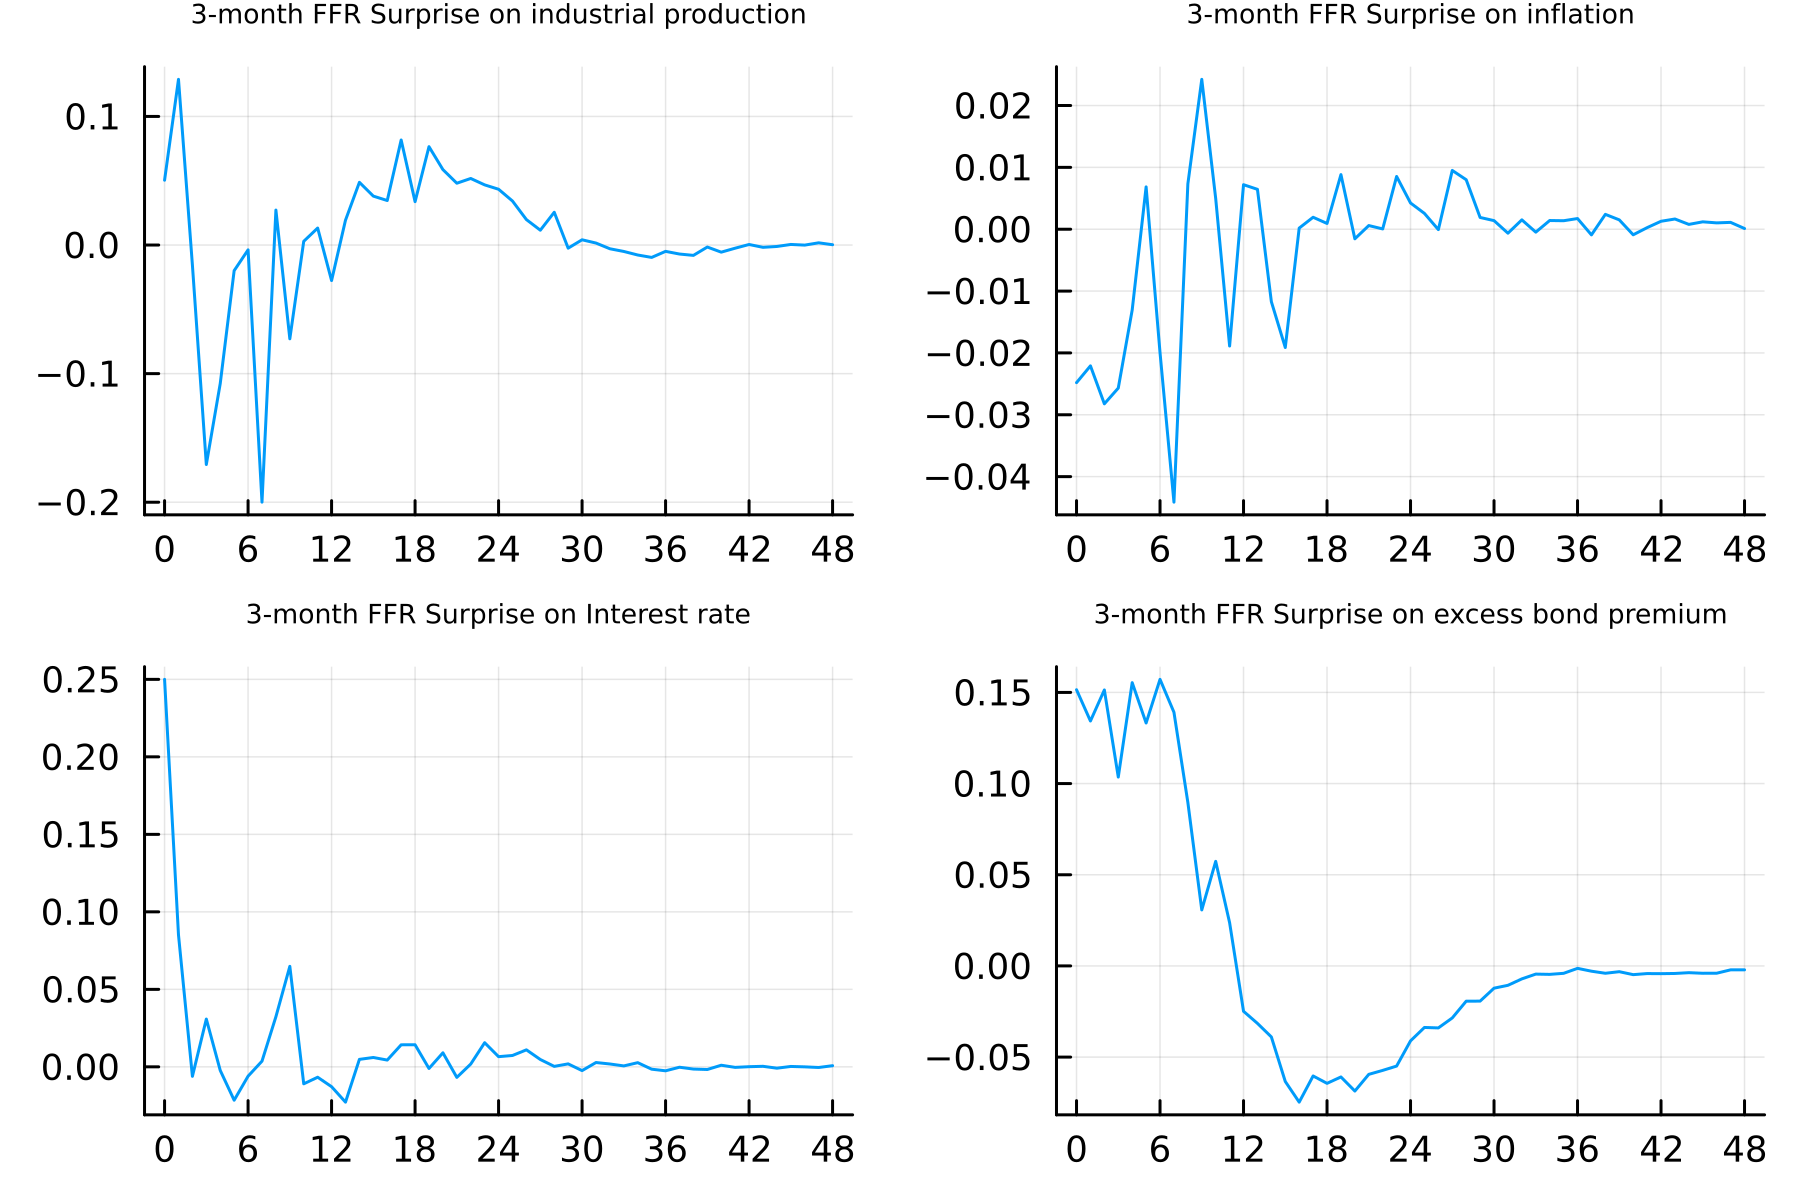

In [44]:
fig = plot(H, 
collect(eachslice(Θ̂_mps; dims = 1)), 
layout = (2,2), 
legend = :none, 
title = permutedims(["3-month FFR Surprise on "*i for i in [
    "industrial production", 
    "inflation", 
    "Interest rate", 
    "excess bond premium"
    ]
    ]),
titlefontsize = 6, xticks = 0:6:48, dpi = 300)

By using an external instrument for monetary policy shock, the price puzzle diseappears and industrial production decreases (ignoring the initial jump), as expected. There is also a much clearer increasing pattern on the excess bond premium compared to the SIRF without the external instrument.

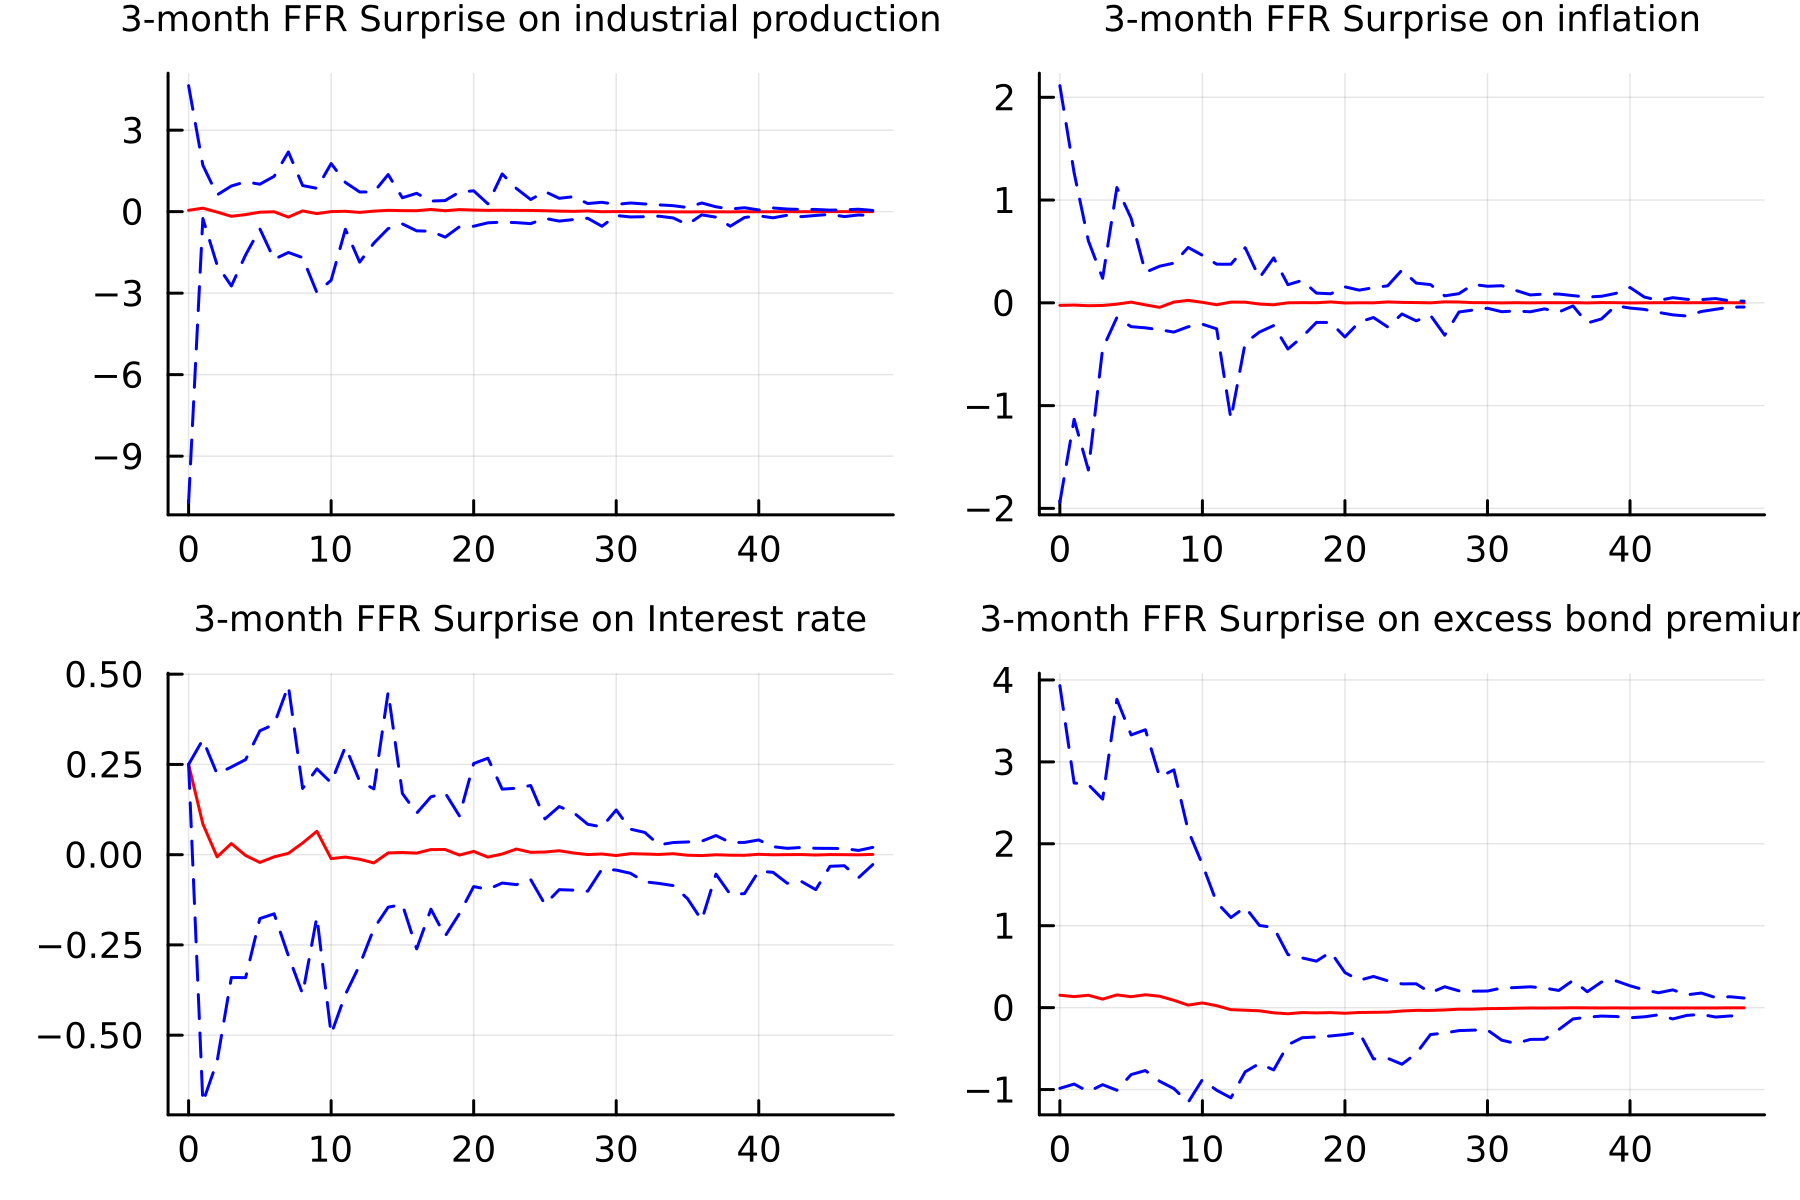

In [45]:
LR_l, LR_u = bootstrap(y, p, iv_id, 100, 0.1, H, ff4_tc, 3);

LR_l_mps = LR_l * .25;
LR_u_mps = LR_u * .25;


titles = ["industrial production", "inflation", "Interest rate", "excess bond premium"]

plot([plot(
    H, 
    [collect(eachslice(Θ̂_mps; dims = 1))[i] collect(eachslice(LR_l_mps; dims = 1))[i] collect(eachslice(LR_u_mps; dims = 1))[i]], 
    title = "3-month FFR Surprise on "*titles[i], 
    titlefontsize = 8, color = [:red :blue :blue], 
    linestyle = [:solid :dash :dash]) for i in 1:4]..., 
    fillalpha = 1, layout = (2, 2), 
    legend = :none, 
    dpi = 300
    )

The confidence interval is significantly larger than the interval obtained without the external instrument, suggesting that instrument weakness may be a major issue. This could be due in part to differencing the variables (and in particular gs1), which might have made the instrument weaker than it already was. 

## Estimation in Levels

I try the same exercise in levels instead of first-differences to see whether I can gain accuracy.

In [46]:
y = merge(logip, logcpi, gs1, ebp);

In [47]:
maxLags = 12;
AICTest(y, maxLags)[1]

12×2 DataFrame
 Row │ Lags   AIC_Score 
     │ Int64  Float32   
─────┼──────────────────
   1 │    12   -8.77354
   2 │    11   -8.74932
   3 │    10   -8.61217
   4 │     9   -8.43414
   5 │     8   -8.44538
   6 │     7   -8.42627
   7 │     6   -8.35715
   8 │     5   -8.28399
   9 │     4   -8.27213
  10 │     3   -8.23077
  11 │     2   -8.09614
  12 │     1   -7.5361

In [48]:
AICTest(y, maxLags)[2]

12

In [49]:
BICTest(y, maxLags)[1]

12×2 DataFrame
 Row │ Lags   BIC_Score 
     │ Int64  Float32   
─────┼──────────────────
   1 │    12   -6.80294
   2 │    11   -6.93959
   3 │    10   -6.9633
   4 │     9   -6.94614
   5 │     8   -7.11824
   6 │     7   -7.26
   7 │     6   -7.35175
   8 │     5   -7.43945
   9 │     4   -7.58846
  10 │     3   -7.70796
  11 │     2   -7.73419
  12 │     1   -7.33502

In [50]:
BICTest(y, maxLags)[2]

2

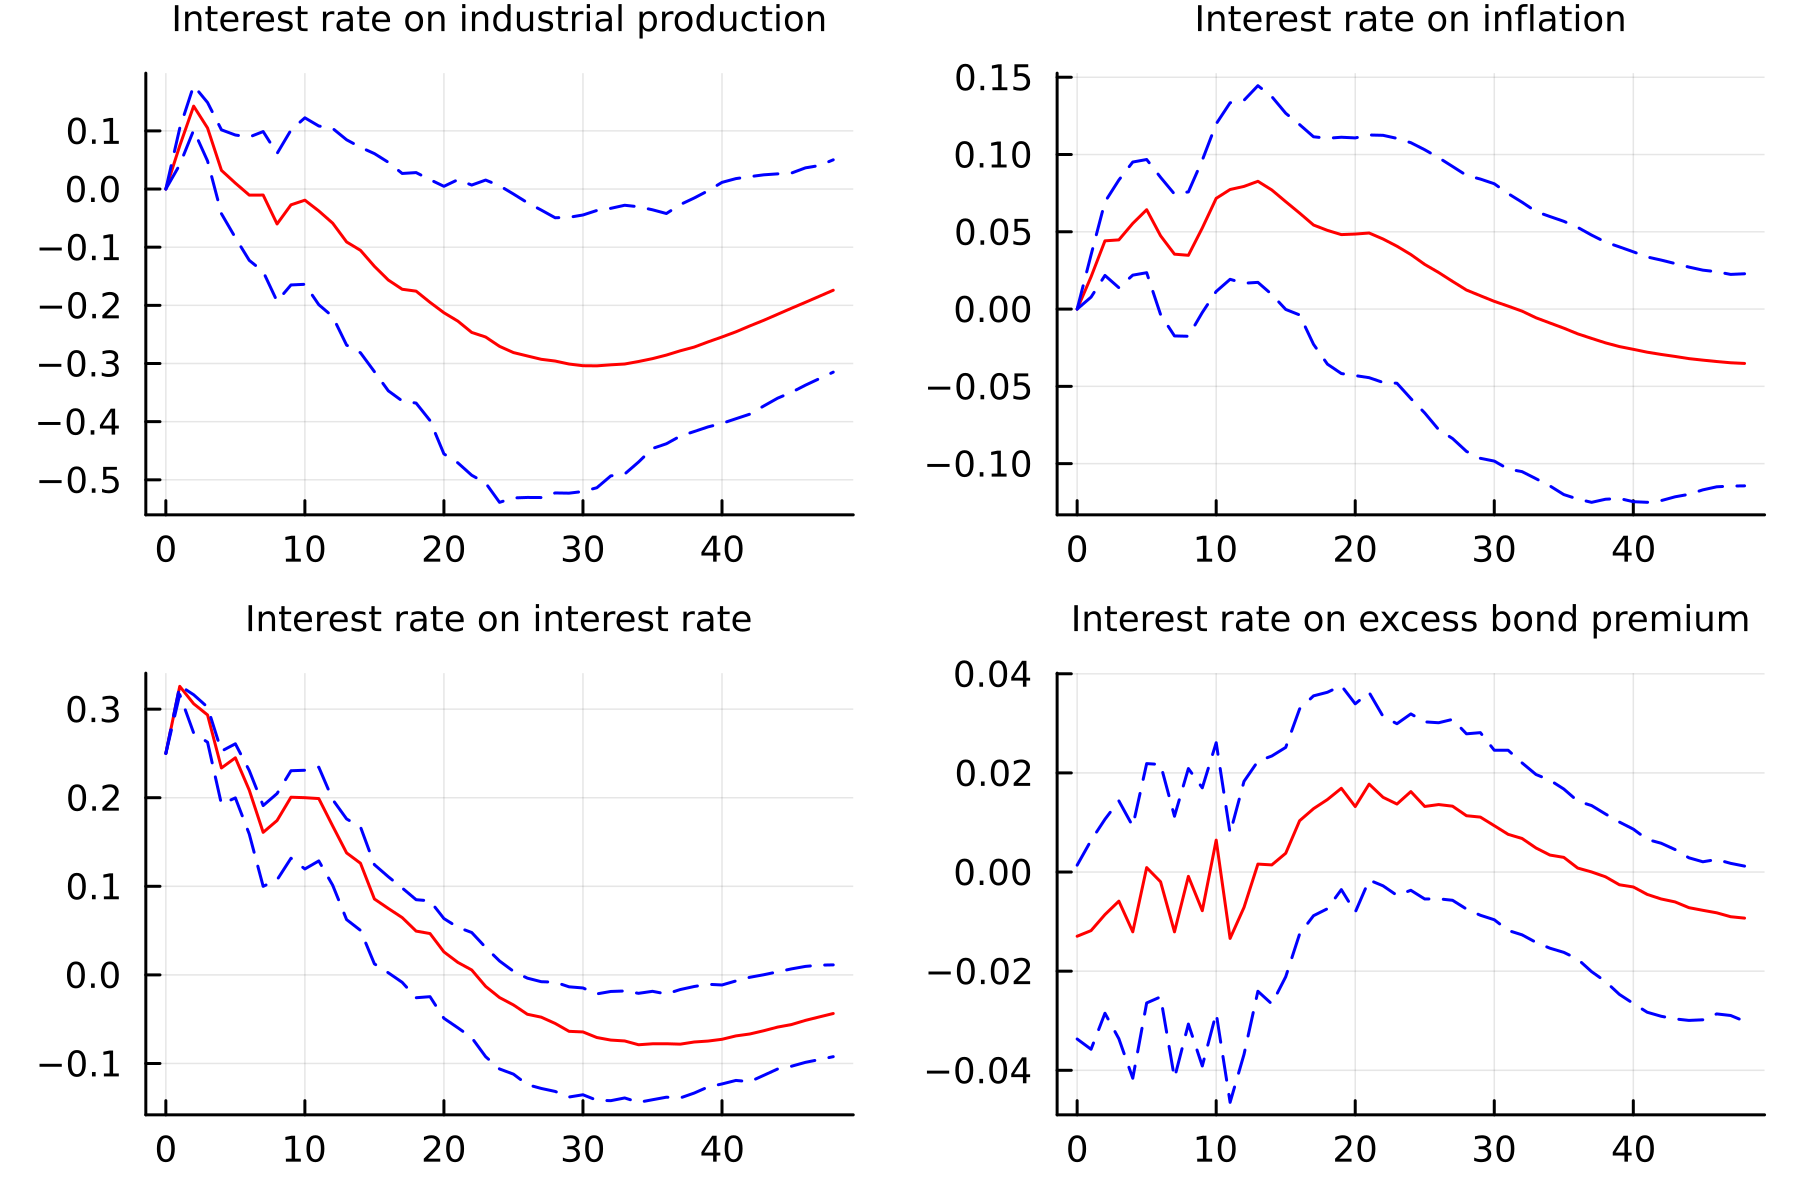

In [51]:
p = 12;
B̂, Σ̂, ε̂ = VAR(y, p);

H = 0:48
Θ̂ = SIRF(B̂, Σ̂, H);

# scale such that variables react to a 25bp increase in mpi
Θ̂_mps  = Θ̂[:, 3, :] ./ Θ̂[3, 3, 1] * .25; 

LR_l, LR_u = bootstrap(y, p, recursive_id, 100, 0.1, H);

LR_l_mps = LR_l[:, 3, :] ./ LR_l[3, 3, 1] * .25; 
LR_u_mps = LR_u[:, 3, :] ./ LR_u[3, 3, 1] * .25; 

titles = ["industrial production", "inflation", "interest rate", "excess bond premium"]

plot([plot(
    H, 
    [collect(eachslice(Θ̂_mps; dims = 1))[i] collect(eachslice(LR_l_mps; dims = 1))[i] collect(eachslice(LR_u_mps; dims = 1))[i]], 
    title = "Interest rate on "*titles[i], 
    titlefontsize = 8, color = [:red :blue :blue], 
    linestyle = [:solid :dash :dash]) for i in 1:4]..., 
    fillalpha = 1, layout = (2, 2), 
    legend = :none, 
    dpi = 300
    )

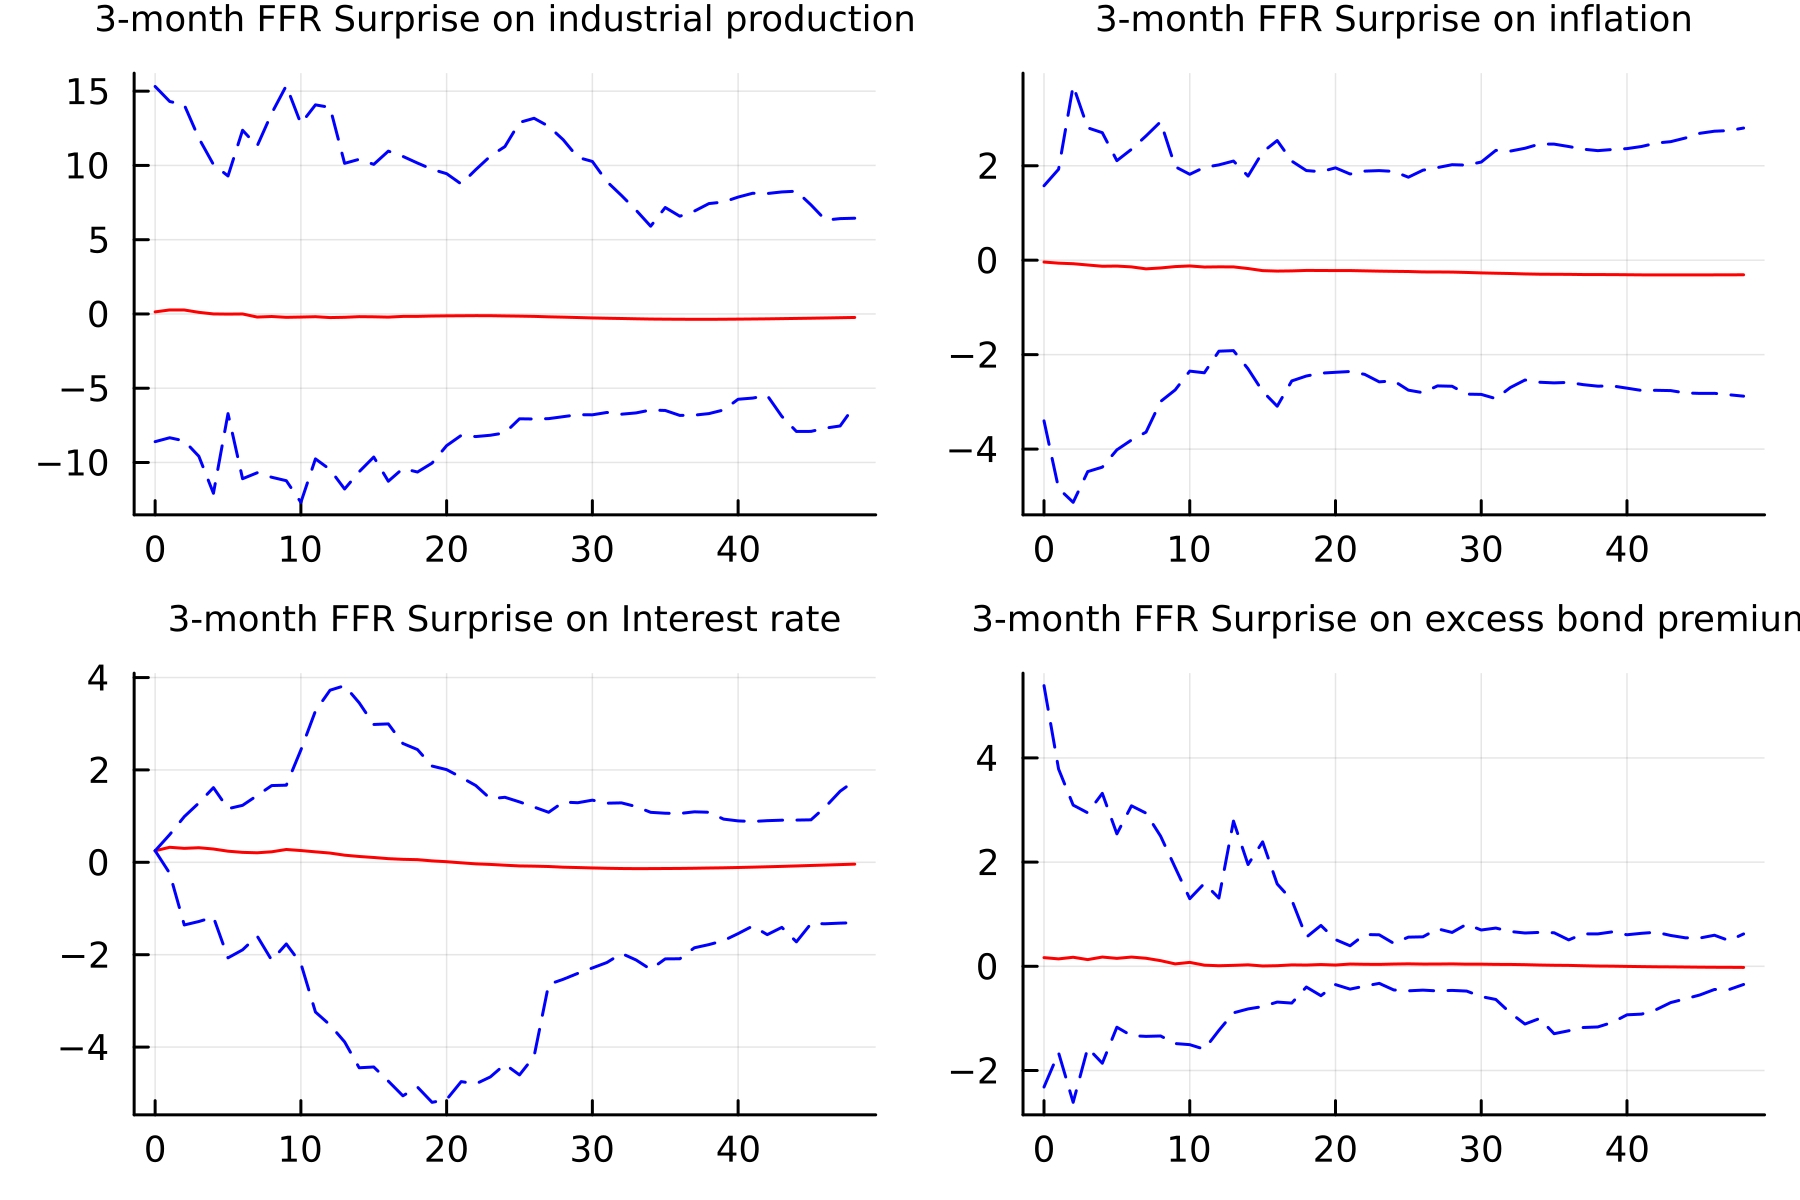

In [52]:
#b̂[1, 1] = cov(ε̂[:, 1], values(ff4_tc)) / StatsBase.var(values(ff4_tc));
#b̂[2, 1] = cov(ε̂[:, 2], values(ff4_tc)) / StatsBase.var(values(ff4_tc));
#b̂[3, 1] = cov(ε̂[:, 3], values(ff4_tc)) / StatsBase.var(values(ff4_tc));
#b̂[4, 1] = cov(ε̂[:, 4], values(ff4_tc)) / StatsBase.var(values(ff4_tc));

#p = 12;
#B̂, Σ̂, ε̂ = VAR(y, p);

#sizediff = size(ε̂, 1) - size(ff4_tc, 1)
#ε̂ = ε̂[sizediff+1:end, :] 

sizediff = size(y, 1) - size(ff4_tc, 1)
y = y[(sizediff+1):end]

p = 12;
B̂, Σ̂, ε̂ = VAR(y, p);

b̂ = zeros(4, 1);

b̂[1, 1] = cov(ε̂[:, 1], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[2, 1] = cov(ε̂[:, 2], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[3, 1] = cov(ε̂[:, 3], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);
b̂[4, 1] = cov(ε̂[:, 4], values(ff4_tc)[(p+1):end]) / StatsBase.var(values(ff4_tc)[(p+1):end]);


b̂₃ = b̂[3, 1];

Θ̂₀₃ = b̂ ./ b̂₃;

Cₕ = Cₛ(B̂, H);
Θ̂ₕ = cat(map(c -> c*Θ̂₀₃, Cₕ)...; dims = 2);

# scale such that variables react to a 25bp increase in mpi
Θ̂_mps  = Θ̂ₕ * .25; 

LR_l, LR_u = bootstrap(y, p, iv_id, 100, 0.1, H, ff4_tc, 3);

LR_l_mps = LR_l * .25;
LR_u_mps = LR_u * .25;


titles = ["industrial production", "inflation", "Interest rate", "excess bond premium"]

plot([plot(
    H, 
    [collect(eachslice(Θ̂_mps; dims = 1))[i] collect(eachslice(LR_l_mps; dims = 1))[i] collect(eachslice(LR_u_mps; dims = 1))[i]], 
    title = "3-month FFR Surprise on "*titles[i], 
    titlefontsize = 8, color = [:red :blue :blue], 
    linestyle = [:solid :dash :dash]) for i in 1:4]..., 
    fillalpha = 1, layout = (2, 2), 
    legend = :none, 
    dpi = 300
    )

The confidence intervals remain large even after estimating the VAR in levels.